Number of samples in the training set: 12567
Number of samples in the validation set: 2040
Number of samples in the test set: 3255
Train data X shape: (12567, 768)
Train data y shape: (12567, 3, 3)


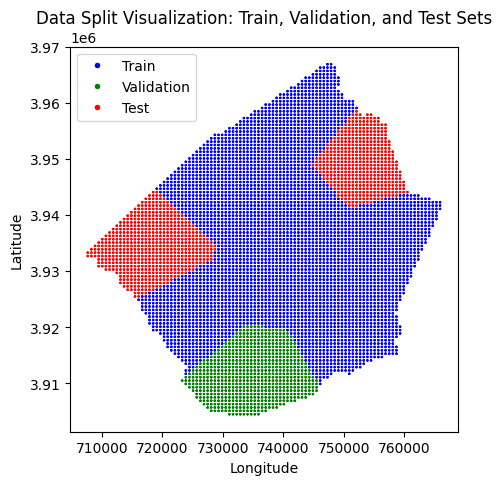

In [6]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import random
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set a fixed random seed for reproducibility
random.seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf_train_test = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

# Extract centroid coordinates of each tile
gdf_train_test['centroid'] = gdf_train_test.geometry.centroid

# Decide on the number of clusters
n_clusters = 10  # Adjust based on your requirements
# Use coordinates without scaling
coords = np.array([[geom.x, geom.y] for geom in gdf_train_test['centroid']])
# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=19)
gdf_train_test['cluster'] = kmeans.fit_predict(coords)

# Get unique clusters
clusters = gdf_train_test['cluster'].unique()
np.random.shuffle(clusters)

# Split clusters into train, validation, and test sets
train_clusters = clusters[:7]    # Clusters 0 to 6 (70%)
val_clusters = clusters[7:8]     # Cluster 7 (10%)
test_clusters = clusters[8:]     # Clusters 8 and 9 (20%)

# Filter the original DataFrame to create the train, validation, and test DataFrames
train_gdf = gdf_train_test[gdf_train_test['cluster'].isin(train_clusters)].reset_index(drop=True)
val_gdf = gdf_train_test[gdf_train_test['cluster'].isin(val_clusters)].reset_index(drop=True)
test_gdf = gdf_train_test[gdf_train_test['cluster'].isin(test_clusters)].reset_index(drop=True)


# Define feature and target columns
X_cols = [col for col in gdf_train_test.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

# Prepare data arrays for train, validation, and test
X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3)

X_val = val_gdf[X_cols]
y_val = np.stack(val_gdf[y_col].values).reshape(-1, 3, 3)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 9), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

# Create a mapping from clusters to sets
cluster_to_set = {}
for cluster in train_clusters:
    cluster_to_set[cluster] = 'Train'
for cluster in val_clusters:
    cluster_to_set[cluster] = 'Validation'
for cluster in test_clusters:
    cluster_to_set[cluster] = 'Test'

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Display the number of samples in each split
print(f"Number of samples in the training set: {len(train_gdf)}")
print(f"Number of samples in the validation set: {len(val_gdf)}")
print(f"Number of samples in the test set: {len(test_gdf)}")

print("Train data X shape:", X_train.values.shape)
print("Train data y shape:", y_train.shape)

# Plot the data points colored by 'set'
plt.figure(figsize=(5, 5))

# Define colors for each set
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}

# Map 'set' labels to colors
point_colors = gdf_train_test['set'].map(colors)

# Plot
plt.scatter(coords[:, 0], coords[:, 1], c=point_colors, s=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='green', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=5)
]

plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Split Visualization: Train, Validation, and Test Sets')
plt.show()

In [7]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.03400826 0.03482689 0.0335786 ]
 [0.03508722 0.03436134 0.03405821]
 [0.03550249 0.03414185 0.03406537]]
Baseline MSE on Test Set: 0.0034263483248651028
Baseline MAE on Test Set: 0.03804613649845123


In [8]:
def train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor=None, 
    y_val_tensor=None, 
    epochs=100, 
    criterion=nn.MSELoss(), 
    optimizer=None, 
    lr=0.001, 
    batch_size=32, 
    verbose=True,
    use_batch_processing=True, 
    early_stopping=False,  # New argument to enable early stopping
    patience=10,  # Number of epochs with no improvement before stopping
    min_delta=0.0  # Minimum improvement to reset patience
):
    # Set up optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for batch processing if enabled
    if use_batch_processing:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # No batch processing; use the entire dataset in each pass
        train_loader = [(X_train_tensor, y_train_tensor)]

    # Early stopping initialization
    best_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average training loss
        avg_loss = total_loss / len(train_loader)

        # Print epoch loss every 10 epochs if verbose is enabled
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.4f}')

        # Early stopping check (only if validation data is provided)
        if early_stopping and X_val_tensor is not None and y_val_tensor is not None:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()

            if verbose and (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}')

            # Check for improvement
            if val_loss < best_loss - min_delta:
                best_loss = val_loss
                patience_counter = 0  # Reset patience if there is improvement
            else:
                patience_counter += 1  # Increment patience if no improvement

            # Stop training if patience is exceeded
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {best_loss:.4f}")
                break

    return model

In [9]:
# Simple fully connected (dense) neural network 

class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)  # Output layer matches the size of the 3x3 grid
    
    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
simple_nn_model = SimpleNN(input_size=768, output_size=9, hidden_units=128)
trained_simple_nn_model = train_model(
    model=simple_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  # Validation data
    y_val_tensor=y_val_tensor,  # Validation target
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True,  # Enable early stopping
    patience=20,  # Wait for 20 epochs without improvement
    min_delta=0.0005  # Minimum loss improvement to reset patience
)
# Prediction on test data
with torch.no_grad():
    snn_pred = trained_simple_nn_model(X_test_tensor)

# Calculate metrics
mse_snn = nn.MSELoss()(snn_pred, y_test_tensor).item()
mae_snn = nn.L1Loss()(snn_pred, y_test_tensor).item()

print(f"SimpleNN MSE on Test Set: {mse_snn}")
print(f"SimpleNN MAE on Test Set: {mae_snn}")

Epoch [10/100], Training Loss: 0.0075
Epoch [10/100], Validation Loss: 0.0010
Epoch [20/100], Training Loss: 0.0074
Epoch [20/100], Validation Loss: 0.0010
Early stopping at epoch 21 with Validation Loss: 0.0010
SimpleNN MSE on Test Set: 0.004119581542909145
SimpleNN MAE on Test Set: 0.030970217660069466


In [10]:
# Deep Fully Connected Neural Network

class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer matches 3x3 grid size

    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x) # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
deep_nn_model = DeepNN(input_size=768, output_size=9, hidden_units=128)
trained_deep_nn_model = train_model(
    model=deep_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  
    y_val_tensor=y_val_tensor, 
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True, 
    patience=30, 
    min_delta=0.0005  
)

# Prediction on test data
with torch.no_grad():
    dnn_pred = trained_deep_nn_model(X_test_tensor)

# Calculate metrics
mse_dnn = nn.MSELoss()(dnn_pred, y_test_tensor).item()
mae_dnn = nn.L1Loss()(dnn_pred, y_test_tensor).item()

print(f"DeepNN MSE on Test Set: {mse_dnn}")
print(f"DeepNN MAE on Test Set: {mae_dnn}")

Epoch [10/100], Training Loss: 0.0024
Epoch [10/100], Validation Loss: 0.0008
Epoch [20/100], Training Loss: 0.0016
Epoch [20/100], Validation Loss: 0.0012
Epoch [30/100], Training Loss: 0.0013
Epoch [30/100], Validation Loss: 0.0011
Early stopping at epoch 31 with Validation Loss: 0.0009
DeepNN MSE on Test Set: 0.002177073620259762
DeepNN MAE on Test Set: 0.02516738697886467
